In [140]:
import random
import json
import datetime
import numpy as np
import pandas as pd
import datetime
import math
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn import metrics
import seaborn as sns
import operator
import matplotlib.pyplot as plt

#TODO Change randomized to some distribution to add a trend to the data.

'''
This script generates 1500 samples for project and tasks. The project
data will be used to predict completion time and the task attributes are
generated for the sake of app completion.

Not only this, but the ProjectDataFrame has methods for predicting data within the dataframe.

1. Create Dataframe
2. Generate Samples
3. Run run_and_evaluate_model
'''

class ProjectDataFrame:
    
    def __init__(self,project_data_filepath = None):
        
        # Assuming its csv for now because we generated the data
        if project_data_filepath is not None:
            self.df = pd.read_json(project_data_filepath)
            self.predictors = [] # All variables starting out, specifically for eda
            self.target = []
            self.predictors_dummy # After all the model methods are ran, an attribute called, this will store the variables used
            
        self.seed = random.seed(random.randrange(1,10000)) # Random seed just chose a number
        self.df = None

    def __str__(self):
        return '{} samples\n{} columns'.format(self.df.shape[0], self.df.shape[1])
        
    @staticmethod
    def _generate_project_sample(id):
        '''
        sample = generate_sample(1). Creates a random sample with unit_id = 1
        '''
        project_dict = {
            "project_id": id,
            "team_size": random.randint(1,50),
            "budget": math.floor(random.random() * 2000000),
            # Workload is based off of story points
            "workload": random.choice(['Light','Moderate','Heavy']),
            "cumulative_experience_years": random.randint(10,200),
            "completion_time_days": random.randint(50,360),
        }

        return project_dict
    

    def create_project_samples(self):
        records = [self._generate_project_sample(i) for i in range(1500)]
        self.df = pd.DataFrame(records)

    def head(self):
        return self.df.head()
    
    def describe(self):
        return self.df.describe()
    
    def get_eda_plots(self):
        to_drop = ['project_id']
        plot_df = self.df.drop(to_drop,axis=1)

        # Plot the variables
        sns.pairplot(plot_df)

    
    def _prep_linear_regression(self):
        
        predictor_columns = self.df.columns.drop('completion_time_days')
        predictors = [col for col in predictor_columns if 'id' not in col]; self.predictors = predictors
        target = ["completion_time_days"]

        
        X = self.df.loc[:,predictors]
        y = self.df.loc[:,target]

        X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = self.seed, test_size=0.33)
        
        # Get dummies for catagorical variables
        X_train_dummified = pd.get_dummies(X_train)
        X_test_dummified = pd.get_dummies(X_test)

        # Save predictor dummy labels to class instance
        self.predictors_dummy = X_train_dummified.columns.to_list()
    
        return (X_train_dummified,X_test_dummified,y_train,y_test)

    def _run_linear_regression(self):
        '''
        Run the linear regression model and create column. Return y_test and y_pred for evaluation
        '''
        # Prepare the model by creating predictor 2D array and 1D target array
        X_train, X_test, y_train, y_test = self._prep_linear_regression()
        model = LinearRegression().fit(X_train,y_train)

        # Fit the training data to the model and store predicted test into array for evaluation
        y_pred = model.predict(X_test)

        # Save model coefficiants to instance
        self.model_coeff = model.coef_.tolist()[0]

        return (y_test, y_pred, model)
    
    def run_and_evaluate_model(self):
        '''
        This method returns a model object so that
        '''
        # Run and evaulate the model using mean squared error
        y_true, y_pred, model = self._run_linear_regression()

        r2 = metrics.r2_score(y_true,y_pred)
        print(f'R2 Score: {metrics.r2_score(y_true,y_pred)}')

        return model
    
    def get_feature_importance(self):
        
        var_list = [var for var in self.predictors_dummy]
        ceoff_list = [abs(coeff) for coeff in self.model_coeff]
        to_sort = []

        for var,coeff in zip(var_list,ceoff_list):
            to_sort.append((var,coeff))
        
        sorted_list = sorted(to_sort,key=lambda ele: ele[1], reverse=True)
        
        # Generate plot of feature importance
        test_df = pd.DataFrame(sorted_list, columns=['Feature','Ceofficient_Magnitude'])
        fig, ax = plt.subplots()
        sns.barplot(test_df,x = 'Feature', y = 'Ceofficient_Magnitude')
        fig.set_size_inches(15,10)
        plt.title("Feature Importance by Regression Coefficients")
        plt.show()




        
class TaskDataFrame():

    def __init__(self, task_data_filepath = None):
        
        if task_data_filepath is not None:
            self.df = pd.read_json(task_data_filepath)
        
        self.seed = random.seed(random.randrange(1,1000)) # Random seed just chose a number
        self.df = None

    def __str__(self):
        return '{} samples\n{} columns'.format(self.df.shape[0], self.df.shape[1])


    @staticmethod
    def _generate_name():

        first_names = ["Allison", "John", "Becky", "Romeo", "Hunter", "Kappa", "Jing", "Jared"]
        last_names = ['Python', 'Scheme', 'Java', 'R', 'Polar', 'Mouse', 'Random', "Smith", "Flather", "Scala", "Camel"] 

        return ' '.join([random.choice(first_names),random.choice(last_names)])
    

    @staticmethod
    def _generate_datetime(start,end):
        '''
        generate_datetime(start datetime,end datetime)
        '''
        return start + datetime.timedelta(
            seconds = random.randint(0, int((end - start).total_seconds())))
        

    def _generate_task_sample(self,id):

        task_dict = {
        "proeject_id": random.randint(0,5),
        "task_id": id,
        "status": random.choice(['Complete','In progress', 'Not complete']), # Update status from due_date in dataframe
        "person_assigned": str(self._generate_name()),
        "due_date": self._generate_datetime((datetime.datetime.now()),datetime.datetime(2024,1,1)),
        "estimated_duration_days": random.randint(1,360)

        }

        return task_dict
    
    def create_task_samples(self):
        records = [self._generate_task_sample(i) for i in range(100)]
        self.df = pd.DataFrame(records)


In [141]:
df = ProjectDataFrame()

df.create_project_samples()

model = df.run_and_evaluate_model()

R2 Score: -0.017266335467443383


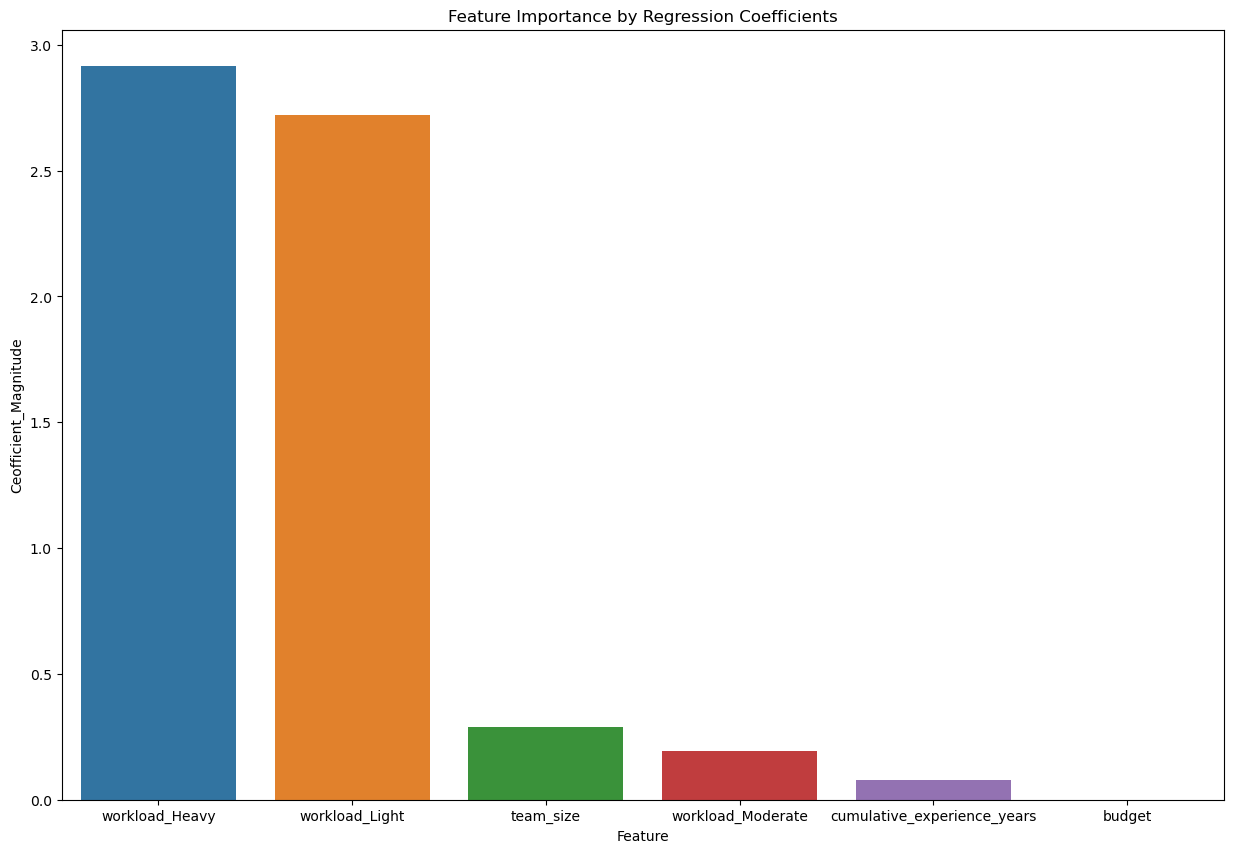

In [142]:
df.get_feature_importance()


In [143]:
print(df.predictors_dummy)
print(df.model_coeff)

['team_size', 'budget', 'cumulative_experience_years', 'workload_Heavy', 'workload_Light', 'workload_Moderate']
[-0.2880383873670183, 5.4919063526372475e-06, -0.07736441170670916, 2.9147280850611774, -2.7217097238125114, -0.1930183612486477]


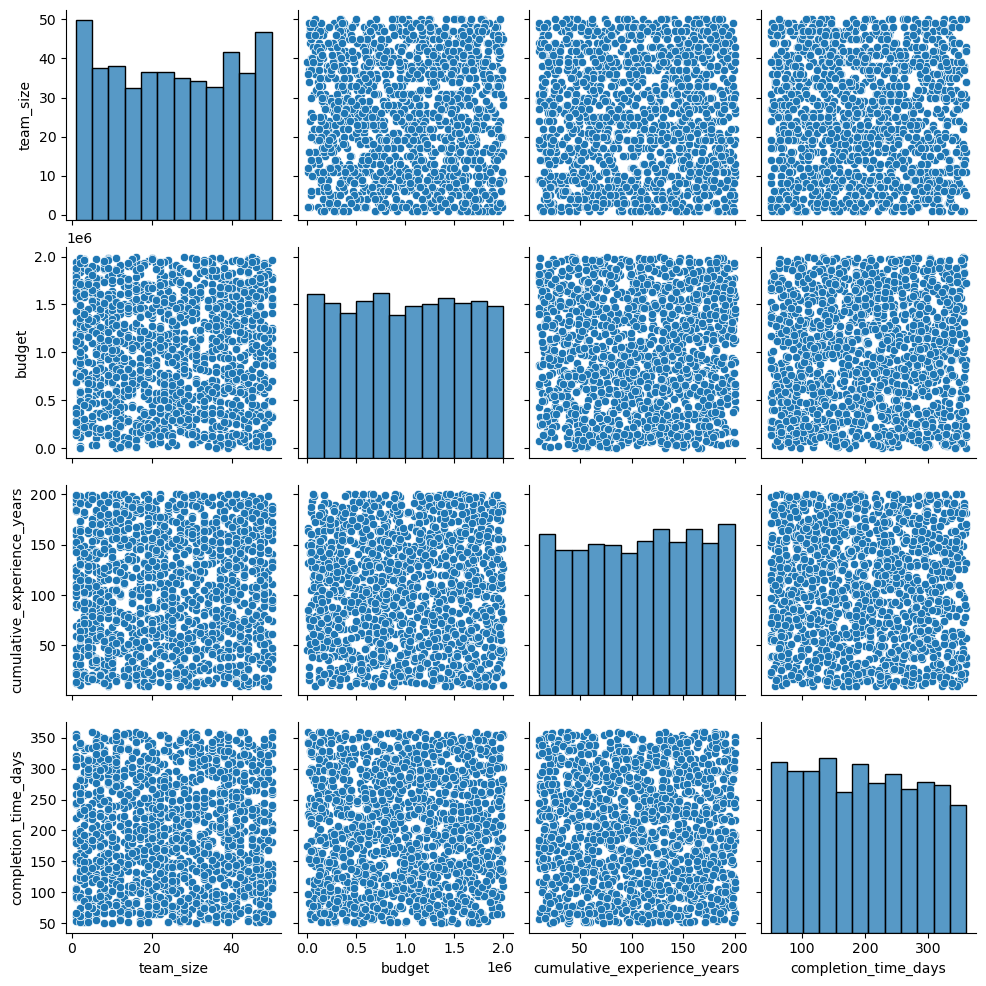

In [144]:
df.get_eda_plots()